## 1. Introduction

This is the final project for the course **CSCA 5652: Introduction to Deep Learning**.

The goal is to classify human emotions using deep learning techniques. The dataset consists of 1,200 human photos with varying types and resolutions, and it is publicly available on [Kaggle](https://www.kaggle.com/datasets/yousefmohamed20/sentiment-images-classifier/data).

The project contains three main steps:

* Exploratory Data Analysis (EDA): Examining and understanding the images to identify patterns, and prepare the data for training.
* Model Architecture: Building multiple models, including a Support Vector Machine (SVM), a vanilla Convolutional Neural Network (CNN), and pretrained CNN models MobileNetV2 and EfficientNetB0, to classify emotions from the images.
* Results and Analysis: Evaluating the performance of the models, tuning hyperparameters to improve prediction accuracy.

## 2. Exploratory Data Analysis (EDA)

In the EDA step, I loaded and inspected the original images, counted the number of images for each emotion, examined their types, and analyzed pixel intensities to observe differences.

In [88]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance

### 2.1 Data Inspection

In [3]:
DATASET_DIR = "/kaggle/input/sentiment-images-classifier/6 Emotions for image classification"
PROCESSED_DIR = "/kaggle/working"

In [4]:
folders = [f for f in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, f))]
print(folders)

['fear', 'sad', 'pain', 'disgust', 'happy', 'anger']


In [92]:
from collections import Counter
import random

def count_images(emotion_path):
    files = [f for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
    return len(files)

def show_emotion_images(emotion_path, emotion):
    images = [f for f in os.listdir(emotion_path)][:2]
    if not images:
        return

    sample_images = random.sample(images, min(2, len(images)))
    
    plt.figure(figsize=(6, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(emotion_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 2, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(emotion, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def plot_image_type_distribution(emotion_path, emotion):
    extensions = [os.path.splitext(f)[1].lower() for f in os.listdir(emotion_path) if os.path.isfile(os.path.join(emotion_path, f))]
    ext_count = Counter(extensions)
    if not ext_count:
        return
    plt.figure(figsize=(5, 4))
    plt.bar(ext_count.keys(), ext_count.values(), color='skyblue')
    plt.title(f"Image type distribution: {emotion}")
    plt.xlabel("Extension")
    plt.ylabel("Count")

    for i, (ext, count) in enumerate(ext_count.items()):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_pixel_intensity(emotion_path, emotion):
    images = [f for f in os.listdir(emotion_path)]
    if not images:
        return

    pixels = []

    for img_file in images:
        try:
            img_path = os.path.join(emotion_path, img_file)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
        
            pixels.append(tf.reshape(img, [-1, 3]))
        except tf.errors.InvalidArgumentError:
            # skip invalid images
            pass
    
    pixels = tf.concat(pixels, axis=0).numpy()

    plt.figure(figsize=(8, 4))
    plt.hist(pixels[:,0], bins=50, color='r', alpha=0.5, label='Red')
    plt.hist(pixels[:,1], bins=50, color='g', alpha=0.5, label='Green')
    plt.hist(pixels[:,2], bins=50, color='b', alpha=0.5, label='Blue')
    plt.title(os.path.basename(emotion_path))
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

fear: 163 images


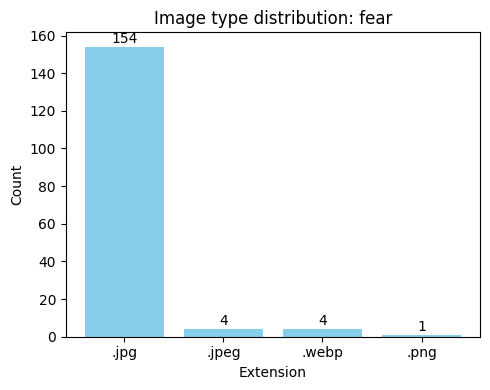

sad: 224 images


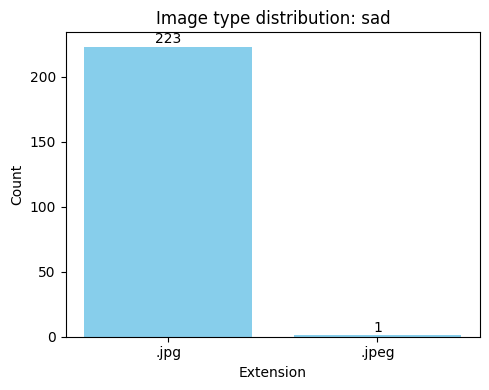

pain: 168 images


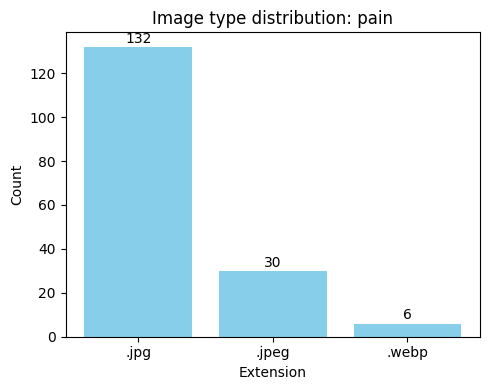

disgust: 201 images


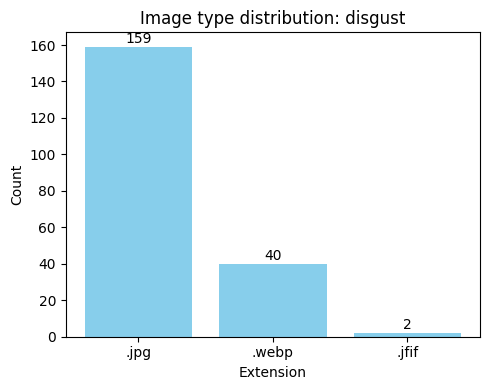

happy: 230 images


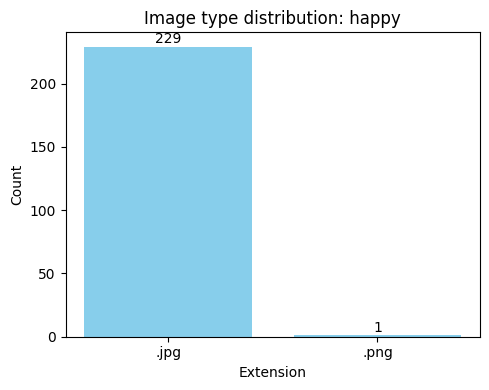

anger: 214 images


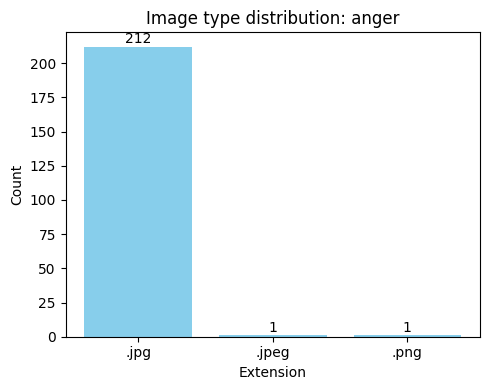

In [7]:
for emotion in folders:
    emotion_path = os.path.join(DATASET_DIR, emotion)

    # count images
    total_images = count_images(emotion_path)
    print(f"{emotion}: {total_images} images")
    
    # plot image type distribution
    plot_image_type_distribution(emotion_path, emotion)

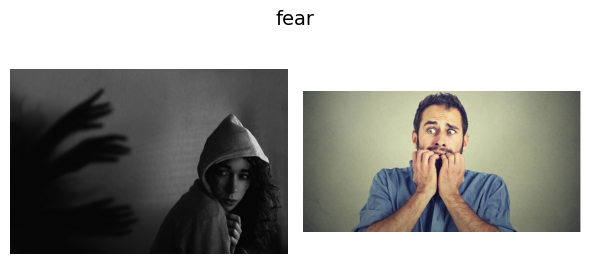

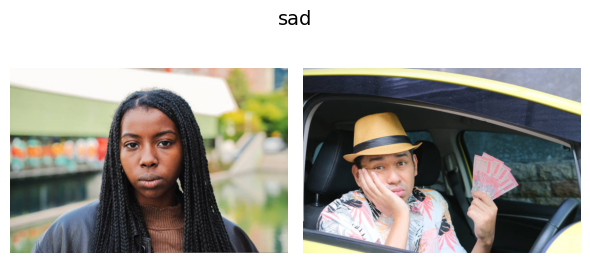

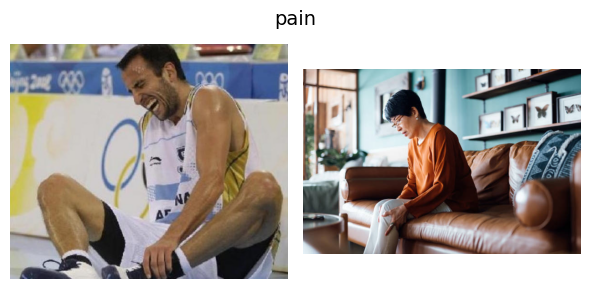

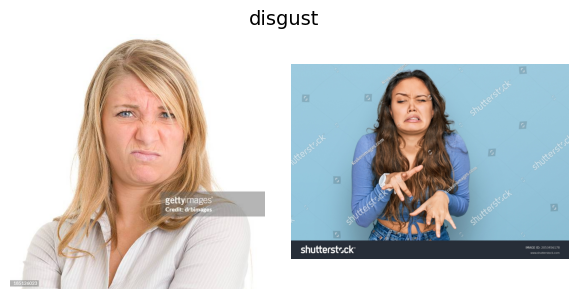

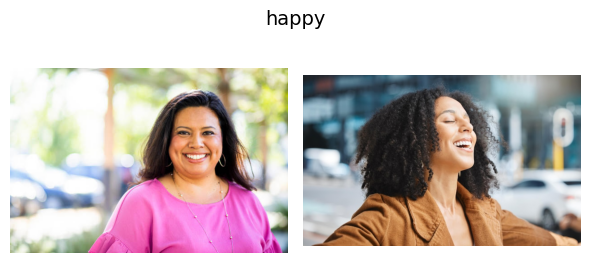

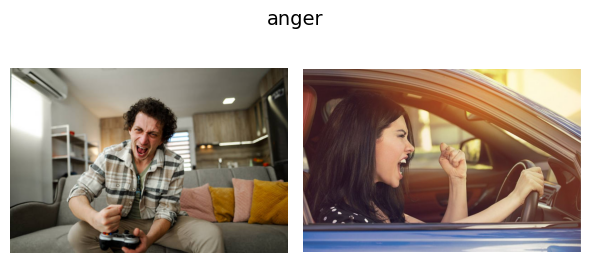

In [6]:
for emotion in folders:
    emotion_path = os.path.join(DATASET_DIR, emotion)

    show_emotion_images(emotion_path, emotion)

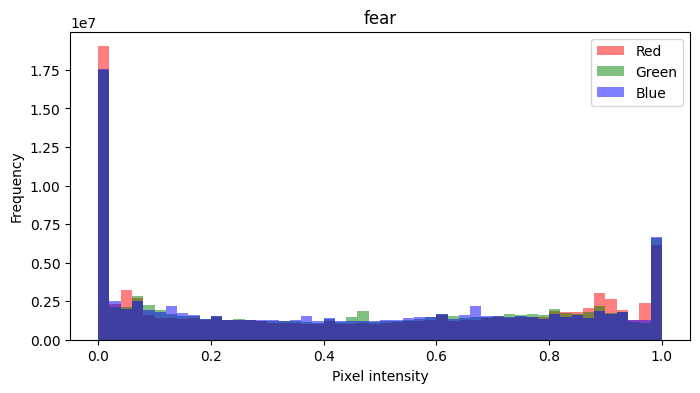

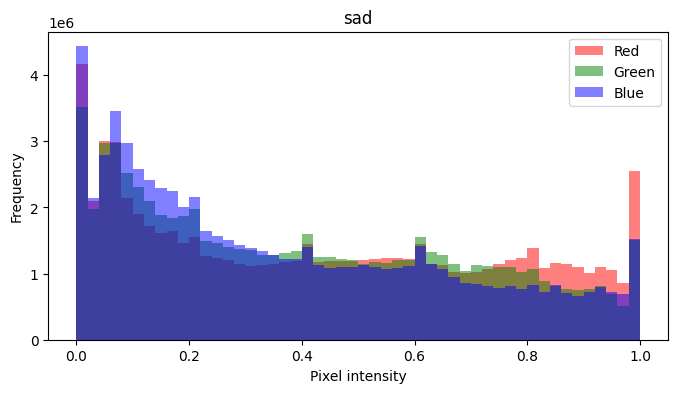

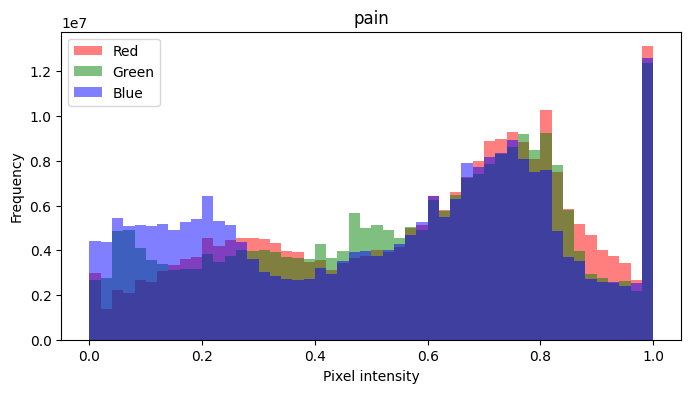

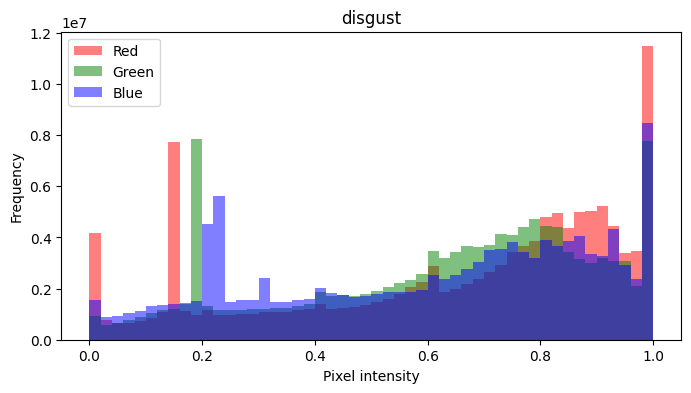

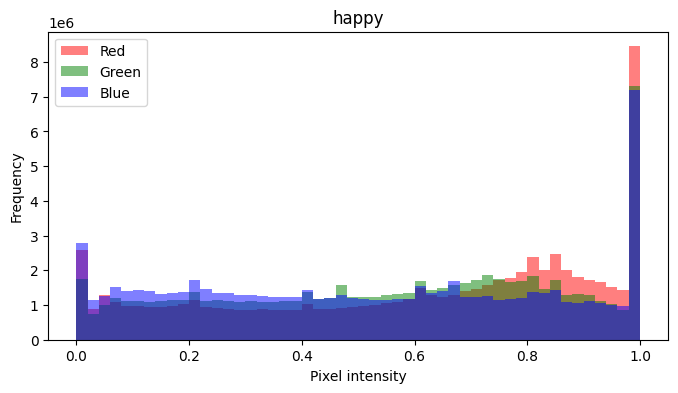

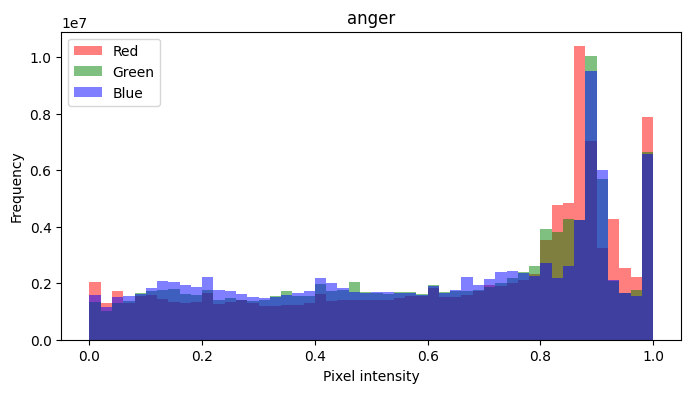

In [93]:
for emotion in folders:
    emotion_path = os.path.join(DATASET_DIR, emotion)

    plot_pixel_intensity(emotion_path, emotion)

### 2.2 Data Preprocessing

From the inspection, I observed the following:
1. The dataset is imbalanced, with “happy” having the most images (230) and “fear” the least (163). Since this could affect the training results, I decided to rebalance the data.
2. The dataset contains multiple image formats (".jpg", ".jpeg", ".webp", ".png", and ".jfif"), with ".jpg" being dominant. To ensure consistency, I converted all images to ".jpg".
3. The images are not square, so I resized them to 64x64 and 128x128 for comparison. I used center cropping instead of padding to avoid introducing misleading pixels.
4. Since pixel intensities vary across emotions, I decided to include pixel colors in the feature extraction process later.
5. Because the dataset only contains 1200 images, I applied data augmentation using horizontal flipping and random brightness. I excluded vertical flipping because it is not appropriate for human faces.

In [8]:
def resize_image(target_size, img):
    width, height = img.size
    target_w, target_h = (target_size, target_size)

    min_side = min(width, height)
    left = (width - min_side) / 2
    top = (height - min_side) / 2
    right = (width + min_side) / 2
    bottom = (height + min_side) / 2

    # center-crop and resize to square
    img_cropped = img.crop((left, top, right, bottom))
    img = img_cropped.resize((target_w, target_h), Image.Resampling.LANCZOS)
    return img

def augment_image(img):
    # random horizontal flip
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    # random brightness (0.8x–1.2x)
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(random.uniform(0.8, 1.2))
    return img

def select_random_images(emotion_path, count):
    files = [f for f in os.listdir(emotion_path)]

    if len(files) <= count:
        selected = files
    else:
        selected = random.sample(files, count)
    
    return selected

In [9]:
TARGET_DATASET_SIZE = 320
TARGET_IMAGE_SIZE = 64
OUTPUT_DIR = os.path.join(PROCESSED_DIR, f"images_{TARGET_IMAGE_SIZE}x{TARGET_IMAGE_SIZE}")

In [10]:
from collections import defaultdict

def generate_data(
    target_image_size=TARGET_IMAGE_SIZE, 
    output_dir=OUTPUT_DIR, 
    target_dataset_size=TARGET_DATASET_SIZE, 
    valid_exts=(".jpg", ".jpeg", ".webp", ".png", ".jfif")
):
    # generate directory for image output
    if os.path.exists(output_dir):
        for f in os.listdir(output_dir):
            os.remove(os.path.join(output_dir, f))
    else:
        os.makedirs(output_dir, exist_ok=True)
    
    data = []
    image_name_counts = defaultdict(int)
    
    for emotion in os.listdir(DATASET_DIR):
        emotion_path = os.path.join(DATASET_DIR, emotion)
        
        for file in os.listdir(emotion_path):
            if not file.lower().endswith(valid_exts):
                continue
    
            img = Image.open(os.path.join(emotion_path, file)).convert("RGB")
            img_resized = resize_image(target_image_size, img)
    
            image_name = os.path.splitext(file)[0]
    
            # rename if images share the same name
            image_name_counts[image_name] += 1
            if image_name_counts[image_name] > 1:
                image_name = f"{image_name}_{image_name_counts[image_name]}"
            
            save_path = os.path.join(output_dir, f"{image_name}.jpg")
            img_resized.save(save_path, "JPEG", quality=100)
    
            data.append({'image_name': image_name, 'emotion': emotion})
    
        # select random images for data augmentation
        image_count = count_images(emotion_path)
        images_to_augment = select_random_images(emotion_path, target_dataset_size - image_count)
        
        for image in images_to_augment:
            img = Image.open(os.path.join(emotion_path, image)).convert("RGB")
            img_augmented = augment_image(img)
            img_resized = resize_image(target_image_size, img_augmented)
            
            image_name = f"{os.path.splitext(image)[0]}"
            
            # rename if images share the same name
            image_name_counts[image_name] += 1
            if image_name_counts[image_name] > 1:
                image_name = f"{image_name}_{image_name_counts[image_name]}_aug"
    
            save_path = os.path.join(output_dir, f"{image_name}.jpg")
            img_resized.save(save_path, "JPEG", quality=100)
    
            data.append({'image_name': image_name, 'emotion': emotion})
    
    df = pd.DataFrame(data, columns=['image_name', 'emotion'])
    
    print(f"Total # of images processed: {len(os.listdir(output_dir))}")
    print(f"Total # of images recorded: {len(df)}")
    print(df.head())
    
    df.to_csv(os.path.join(PROCESSED_DIR, f"image_labels_{target_image_size}.csv"), index=False)

    return df

In [11]:
df = generate_data()

Total # of images processed: 1920
Total # of images recorded: 1920
                                 image_name emotion
0                       Amazon-pricing-rule    fear
1                                    38ruwp    fear
2              photo_11_2023-11-08_20-03-26    fear
3              photo_50_2023-11-08_20-03-26    fear
4  premium_photo-1683740128035-1a4c8b2e1ca3    fear


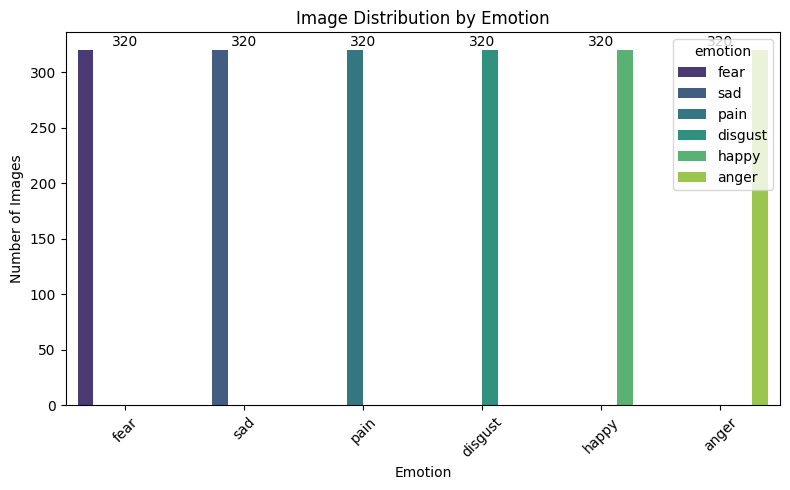

In [95]:
emotion_counts = df['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'count']

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x='emotion',
    y='count',
    hue='emotion',
    data=emotion_counts,
    palette='viridis'
)

for i, row in emotion_counts.iterrows():
    ax.text(i, row['count'] + 1, str(row['count']),
            ha='center', va='bottom', fontsize=10)

plt.title('Image Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
OUTPUT_DIR_128 = os.path.join(PROCESSED_DIR, f"images_128x128")

In [24]:
generate_data(target_image_size=128, output_dir=OUTPUT_DIR_128)

Total # of images processed: 1920
Total # of images recorded: 1920
                                 image_name emotion
0                       Amazon-pricing-rule    fear
1                                    38ruwp    fear
2              photo_11_2023-11-08_20-03-26    fear
3              photo_50_2023-11-08_20-03-26    fear
4  premium_photo-1683740128035-1a4c8b2e1ca3    fear


,image_name,emotion
0,Amazon-pricing-rule,fear
1,38ruwp,fear
2,photo_11_2023-11-08_20-03-26,fear
3,photo_50_2023-11-08_20-03-26,fear
4,premium_photo-1683740128035-1a4c8b2e1ca3,fear
...,...,...
1915,woman-at-computer_2_aug,anger
1916,OIP.qEb4NKvDPMy14OO-xj1c7QHaEK_2_aug,anger
1917,pression-displeasure-actively-gesticulating-be...,anger
1918,h0x3ec6zrclylb6cbh_2_aug,anger


After preprocessing, I obtained two image sets, `images_64x64` and `images_128x128`, each containing 1920 images including the augmented ones. Each emotion now has exactly 320 images, which ensures a balanced dataset for training. I also created two text tables `image_labels_64.csv` and `image_labels_128.csv` with the image names and their corresponding emotion labels.

## 3. Model Architecture

For the image classification task on this small dataset, I chose the following models for comparison:

- **Support Vector Machine (SVM)**: performs well in high-dimensional spaces and can handle smaller datasets effectively.
- **Vanilla CNN**: to establish a baseline and observe how a simple architecture performs without transfer learning.
- **MobileNetV2**: lightweight and efficient, suitable for faster training.
- **EfficientNetB0**: offers a good balance between accuracy and model size through compound scaling.

Before training the models, I split the dataset into 80% training data and 20% validation data to evaluate the models’ performance on unseen data.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df = pd.read_csv(os.path.join(PROCESSED_DIR, "image_labels_64.csv"))
df['image_path'] = df['image_name'].apply(lambda x: f"{OUTPUT_DIR}/{x}.jpg")

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], shuffle=True, random_state=42)
y_train = train_df['emotion'].values
y_val = val_df['emotion'].values

## 3.1 Feature Extraction + Support Vector Machine (SVM)

For training the SVM, I first performed feature extraction by combining HOG (Histogram of Oriented Gradients) features from grayscale images with pixel color information. I used HOG to capture facial structure and edge patterns, since SVMs rely on well-defined feature representations rather than raw pixels. I added color features because the pixel intensity differences across emotions can provide additional useful cues.

In [14]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog

def extract_hog(img_path, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9):
    img = imread(img_path)
    # convert to grayscale
    gray = rgb2gray(img)
    
    feat = hog(gray, orientations=orientations,
               pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block,
               block_norm='L2-Hys')
    return feat

def extract_pixels(img_path):
    img = imread(img_path)
    pixels = img.flatten()
    return pixels / 255.0

def combine_hog_rgb(img_path):
    hog_feat = extract_hog(img_path)
    rgb_feat = extract_pixels(img_path)
    combined = np.concatenate([hog_feat, rgb_feat])
    return combined

After feature extraction, I also scaled the data and applied PCA (Principal Component Analysis) to reduce dimensionality and remove redundancy.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train = np.array([combine_hog_rgb(p) for p in train_df['image_path'].tolist()])
X_val = np.array([combine_hog_rgb(p) for p in val_df['image_path'].tolist()])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

clf = SVC(kernel='linear', C=1.0, random_state=42)

clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print(classification_report(y_val, y_pred))

Validation Accuracy: 0.6458
              precision    recall  f1-score   support

       anger       0.67      0.62      0.65        64
     disgust       0.71      0.77      0.74        64
        fear       0.68      0.75      0.71        64
       happy       0.53      0.53      0.53        64
        pain       0.69      0.64      0.67        64
         sad       0.59      0.56      0.58        64

    accuracy                           0.65       384
   macro avg       0.64      0.65      0.64       384
weighted avg       0.64      0.65      0.64       384



With the basic setting, the SVM achieved an accuracy of 0.6458. From the F1 scores, I observed that some emotions, such as “disgust” and “fear”, were classified more accurately than “happy” and “sad.” In the next section, I searched for better hyperparameters. 

I also prepared training data from the 128×128 images to see whether the image size would make a difference for the SVM.

In [100]:
df_128 = pd.read_csv(os.path.join(PROCESSED_DIR, "image_labels_128.csv"))
df_128['image_path'] = df_128['image_name'].apply(lambda x: f"{OUTPUT_DIR_128}/{x}.jpg")

train_df_128, val_df_128 = train_test_split(df_128, test_size=0.2, stratify=df_128['emotion'], shuffle=True, random_state=42)
y_train_128 = train_df_128['emotion'].values
y_val_128 = val_df_128['emotion'].values

In [101]:
X_train_128 = np.array([combine_hog_rgb(p) for p in train_df_128['image_path'].tolist()])
X_val_128 = np.array([combine_hog_rgb(p) for p in val_df_128['image_path'].tolist()])

## 3.2 Simple CNN

Because the image dataset is quite small for CNN training, I designed a simple architecture with three convolutional blocks and small dropout rates (0.1–0.4). I used this model for training on both the 64×64 and 128×128 image sets, with Flatten instead of GlobalAveragePooling2D to preserve more spatial features.

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def load_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [18]:
X_train_images = load_images(train_df['image_path'].tolist())
X_val_images = load_images(val_df['image_path'].tolist())

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)

In [106]:
def build_simple_cnn(target_image_size=TARGET_IMAGE_SIZE, learning_rate=1e-4):
    model = Sequential([
        Input(shape=(target_image_size, target_image_size, 3)),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
    
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),
    
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
    
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(len(encoder.classes_), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_simple_cnn()
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_153 (Conv2D)             │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_179         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_180         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_181         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_182         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_183         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_184         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,240,678 (8.55 MB)

 Trainable params: 2,239,526 (8.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [26]:
df_128 = pd.read_csv(os.path.join(PROCESSED_DIR, "image_labels_128.csv"))
df_128['image_path'] = df_128['image_name'].apply(lambda x: f"{OUTPUT_DIR_128}/{x}.jpg")

train_df_128, val_df_128 = train_test_split(df_128, test_size=0.2, stratify=df_128['emotion'], shuffle=True, random_state=42)
y_train_128 = train_df_128['emotion'].values
y_val_128 = val_df_128['emotion'].values

In [28]:
X_train_128_images = load_images(train_df_128['image_path'].tolist())
X_val_128_images = load_images(val_df_128['image_path'].tolist())

encoder = LabelEncoder()
y_train_128_encoded = encoder.fit_transform(y_train_128)
y_val_128_encoded = encoder.transform(y_val_128)

y_train_128_cat = to_categorical(y_train_128_encoded)
y_val_128_cat = to_categorical(y_val_128_encoded)

### 3.3 Pretrained CNN Models

I built the pretrained models only on the 128×128 images, since they are not designed to work with smaller inputs.

In [108]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

mobile_net = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
mobile_net.trainable = False

def build_pretrained(model=mobile_net):
    model = Sequential([
        model,
        Flatten(),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_pretrained()
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 6)              │       122,886 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,380,870 (9.08 MB)

 Trainable params: 122,886 (480.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [109]:
from tensorflow.keras.applications import EfficientNetB0

efficient_net = EfficientNetB0(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

efficient_net.trainable = False

model = build_pretrained(efficient_net)
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 6)              │       122,886 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,172,457 (15.92 MB)

 Trainable params: 122,886 (480.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 4. Results and Analysis

### 4.1 SVM

For the SVM, I used grid search to find the best hyperparameters and retrained the model on the validation set. The accuracy increased slightly from 0.6458 to 0.6589, but "happy" was still classified poorly.

In [97]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

print("Best params:", grid.best_params_)

Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [98]:
best_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

best_clf.fit(X_train_pca, y_train)
y_pred = best_clf.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print(classification_report(y_val, y_pred))

Validation Accuracy: 0.6589
              precision    recall  f1-score   support

       anger       0.78      0.56      0.65        64
     disgust       0.61      0.78      0.68        64
        fear       0.86      0.66      0.74        64
       happy       0.64      0.55      0.59        64
        pain       0.63      0.69      0.66        64
         sad       0.56      0.72      0.63        64

    accuracy                           0.66       384
   macro avg       0.68      0.66      0.66       384
weighted avg       0.68      0.66      0.66       384



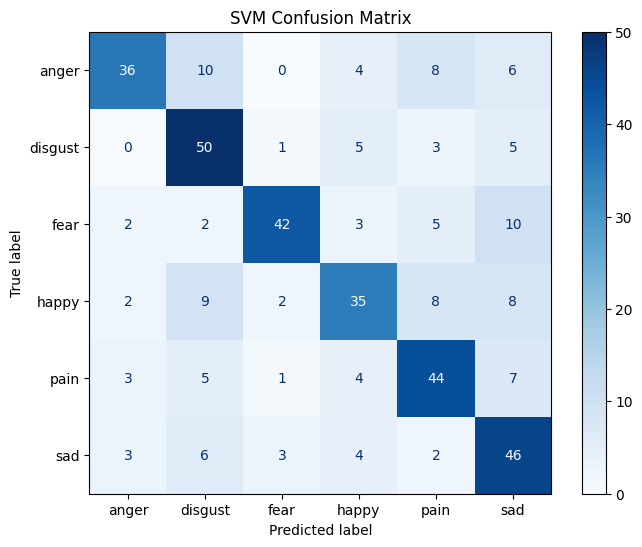

In [99]:
cm = confusion_matrix(y_val, y_pred, labels=best_clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("SVM Confusion Matrix")
plt.show()

Training on the larger images did not improve the accuracy, which suggests that image size is not essential for SVM in this case. Since the model relies on extracted features rather than raw pixel information, increasing the resolution does not provide additional benefits.

In [102]:
scaler = StandardScaler()
X_train_128_scaled = scaler.fit_transform(X_train_128)
X_val_128_scaled = scaler.transform(X_val_128)

pca = PCA(n_components=0.95)
X_train_128_pca = pca.fit_transform(X_train_128_scaled)
X_val_128_pca = pca.transform(X_val_128_scaled)

best_clf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

best_clf.fit(X_train_128_pca, y_train_128)
y_pred_128 = best_clf.predict(X_val_128_pca)

accuracy = accuracy_score(y_val_128, y_pred_128)
print(f"Validation Accuracy (128x128): {accuracy:.4f}")

print(classification_report(y_val_128, y_pred_128))

Validation Accuracy (128x128): 0.6224
              precision    recall  f1-score   support

       anger       0.69      0.55      0.61        64
     disgust       0.61      0.89      0.72        64
        fear       0.90      0.56      0.69        64
       happy       0.67      0.44      0.53        64
        pain       0.62      0.58      0.60        64
         sad       0.47      0.72      0.57        64

    accuracy                           0.62       384
   macro avg       0.66      0.62      0.62       384
weighted avg       0.66      0.62      0.62       384



### 4.2 Simple CNN

I trained the simple CNN on the 64×64 images for 20 epochs. It achieved an accuracy comparable to the SVM, which is reasonable given the small image size. According to the accuracy and loss plots, the model did not show much overfitting on the 64×64 images.

From the confusion matrix, I observed that the poorly classified emotions were consistent with the patterns identified by the SVM.

In [96]:
model = build_simple_cnn()

In [20]:
history = model.fit(
    X_train_images, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_images, y_val_cat),
    verbose=1
)

Epoch 1/20


I0000 00:00:1760098248.707847     102 service.cc:148] XLA service 0x7c1c6c0204f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760098248.708375     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760098249.328676     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1936 - loss: 2.8492

I0000 00:00:1760098254.639055     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.2180 - loss: 2.7213 - val_accuracy: 0.1875 - val_loss: 1.8750
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3432 - loss: 1.9937 - val_accuracy: 0.2786 - val_loss: 1.7623
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4110 - loss: 1.6685 - val_accuracy: 0.3542 - val_loss: 1.6595
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4931 - loss: 1.4543 - val_accuracy: 0.4115 - val_loss: 1.5461
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4985 - loss: 1.4015 - val_accuracy: 0.4479 - val_loss: 1.4767
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5513 - loss: 1.2238 - val_accuracy: 0.4818 - val_loss: 1.4495
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6188 - loss: 1.1008 - val_accuracy: 0.5104 - val_loss: 1.4266
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6171 - loss: 1.0854 - val_accuracy: 0.5391 - val_loss: 1

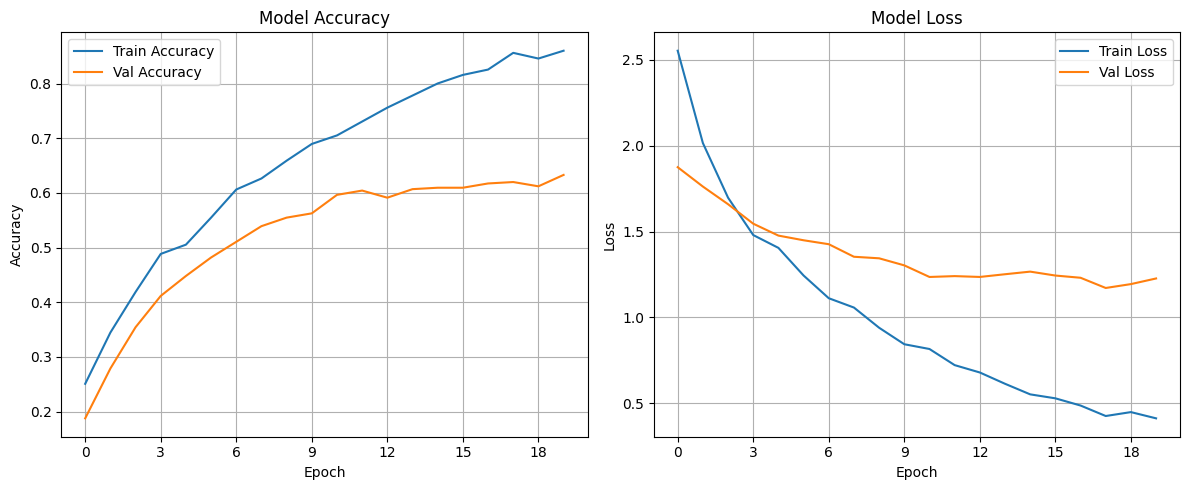

In [21]:
from matplotlib.ticker import MaxNLocator

def plot_history():
    plt.figure(figsize=(12, 5))
    
    # plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

plot_history()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  


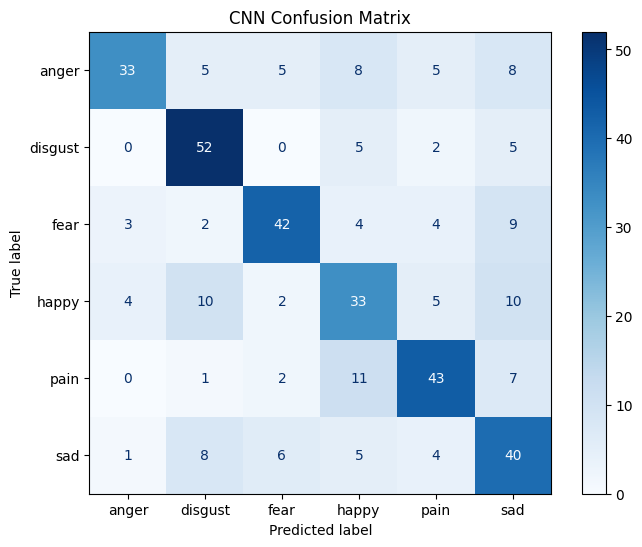

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = model.predict(X_val_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_cat, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("CNN Confusion Matrix")
plt.show()

For the 128×128 images, I applied a learning rate scheduler and early stopping to improve training stability and prevent overfitting. However, training stopped within 20 epochs with a similar accuracy, indicating that the model reached its performance limit.

In [107]:
model = build_simple_cnn(target_image_size=128)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5, # stop if no improvement for 5 epochs
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10, # stop if no improvement for 10 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train_128_images, y_train_128_cat,
    validation_data=(X_val_128_images, y_val_128_cat),
    epochs=40,
    batch_size=32,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.2461 - loss: 2.5515 - val_accuracy: 0.3047 - val_loss: 1.6956 - learning_rate: 1.0000e-04
Epoch 2/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4890 - loss: 1.4210 - val_accuracy: 0.3724 - val_loss: 1.6310 - learning_rate: 1.0000e-04
Epoch 3/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6032 - loss: 1.0562 - val_accuracy: 0.3984 - val_loss: 1.6177 - learning_rate: 1.0000e-04
Epoch 4/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7040 - loss: 0.7919 - val_accuracy: 0.4557 - val_loss: 1.4421 - learning_rate: 1.0000e-04
Epoch 5/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7506 - loss: 0.6554 - val_accuracy: 0.5469 - val_loss: 1.3434 - learning_rate: 1.0000e-04
Epoch 6/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8239 - loss: 0.5035 - val_accuracy: 0.5521 - val_loss: 1.3316 - learning_rate: 1.0000e-04
Epoch 7/40
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8630

### 4.3 MobileNetV2

The simple pretrained MobileNetV2 actually performed worse than my simple CNN model, likely because it was designed for larger input sizes, such as 224×224.

In [79]:
history = model.fit(
    X_train_128_images, y_train_128_cat,
    validation_data=(X_val_128_images, y_val_128_cat),
    epochs=20,
    batch_size=32
)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.1740 - loss: 3.1972 - val_accuracy: 0.3099 - val_loss: 1.8060
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2731 - loss: 2.3873 - val_accuracy: 0.3698 - val_loss: 1.7015
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3161 - loss: 2.1932 - val_accuracy: 0.3906 - val_loss: 1.6060
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3763 - loss: 1.9591 - val_accuracy: 0.4245 - val_loss: 1.5299
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4168 - loss: 1.6969 - val_accuracy: 0.4297 - val_loss: 1.5105
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4733 - loss: 1.5631 - val_accuracy: 0.4609 - val_loss: 1.4421
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4629 - loss: 1.5969 - val_accuracy: 0.4714 - val_loss: 1.4335
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5105 - loss: 1.4055 - val_accuracy: 0.4740 - 

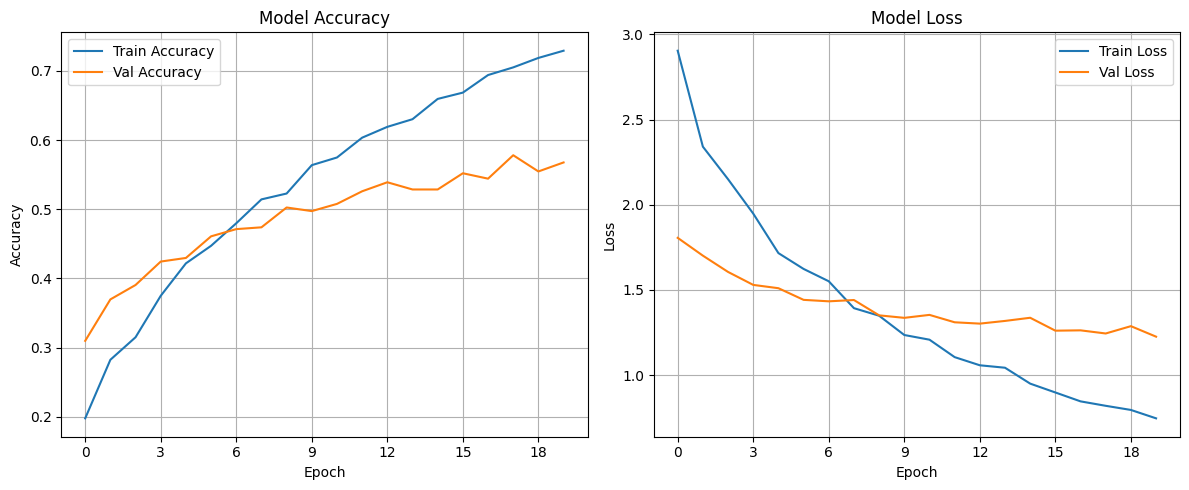

In [80]:
plot_history()

### 4.4 EfficientNetB0

The pretrained EfficientNetB0 performed much better than MobileNetV2 on the 128×128 images. After 50 epochs, it achieved an accuracy of 0.7865 on the validation set, likely because its architecture is more efficient at extracting features even from moderately sized images.

In [86]:
history = model.fit(
    X_train_128_images, y_train_128_cat,
    validation_data=(X_val_128_images, y_val_128_cat),
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.2363 - loss: 2.2176 - val_accuracy: 0.4375 - val_loss: 1.4595 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4759 - loss: 1.4830 - val_accuracy: 0.5521 - val_loss: 1.2516 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5730 - loss: 1.1684 - val_accuracy: 0.5833 - val_loss: 1.1320 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6814 - loss: 0.8909 - val_accuracy: 0.6302 - val_loss: 1.0457 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7030 - loss: 0.7932 - val_accuracy: 0.6510 - val_loss: 0.9778 - learning_rate: 1.0000e-04
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7886 - loss: 0.6494 - val_accuracy: 0.6797 - val_loss: 0.9227 - learning_rate: 1.0000e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.798

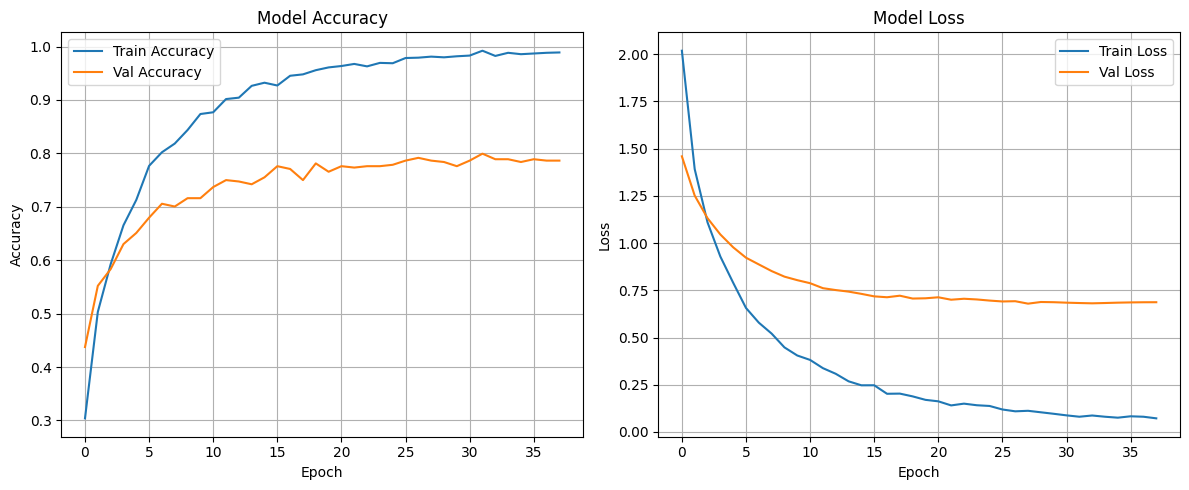

In [87]:
plot_history()

## 5. Conclusion

In this project, I experimented with a supervised learning model (SVM) and various deep learning models to classify human images by 6 emotions. The main challenges I encountered were:

1. The original dataset was quite small, containing only 1,200 images, and it was imbalanced.
2. The images varied in size and type, included background noise, and the faces were not well-centered.
3. Training time and resources were limited, so I only trained on 64×64 and 128×128 images.

From the training results, I observed that feature extraction combined with SVM and the simple CNN achieved comparable accuracy and similar classification performance, with both models performing poorly on “happy” and well on “disgust.” Due to the dataset limitations, the accuracy could not be improved much. The pretrained EfficientNetB0 outperformed MobileNetV2 on the small images, likely due to its more efficient feature extraction.

Future improvements would be:
* Use a larger dataset, resize to higher-resolution images, and apply more data augmentation.
* Apply face detection or cropping to reduce background noise and center the faces.
* Improve the CNN architecture.
* Fine-tune pretrained models instead of using only the classifier head.

This notebook was created and trained on Kaggle and can be found in my [GitHub repo](https://github.com/YuKitAs/human-emotion-classification).

## References

1. Rawat, W., & Wang, Z. (2017). Deep convolutional neural networks for image classification: A comprehensive review. Neural Computation, 29(9), 2352–2449.
2. O’Mahony, N., Campbell, S., Carvalho, A., Harapanahalli, S., Hernandez, G. V., Krpalkova, L., Riordan, D., & Walsh, J. (2019). Deep learning vs. traditional computer vision. Advances in Computer Vision, 128–144.
3. Khan, A., Sohail, A., Zahoora, U., & Qureshi, A. S. (2020). A survey of the recent architectures of deep convolutional neural networks. Artificial Intelligence Review, 53(8), 5455–5516.
4. OpenAI. (2025). ChatGPT (GPT-5) [Large language model]. (Only used for phrasing suggestions and idea refinement; all experiments, coding and results were implemented and validated independently.)